**Description**: Shows how to compare MIP formulations for transportation problems with piecewise linear objective functions.

**Author**: Juan Pablo Vielma

**License**: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

# MIP formulations for piecewise linear functions  with JuMP

We consider the transportation problem
$$\begin{alignedat}{3}
 &\min & \quad  \sum_{s=1}^{n_s} \sum_{d=1}^{n_d} f_{s,d}(x_{s,d})  \\
 \notag&s.t.\\
 &      &  \sum_{d=1}^{n_d} x_{s,d} &= supply_s,  &\quad& \forall s\in \{1,\ldots,n_s\} \\
  &      &   \sum_{s=1}^{n_s} x_{s,d} &= demand_d,  &\quad& \forall d\in \{1,\ldots,n_d\} \\
  &      &  x_{s,d} &\geq 0,  &\quad& \forall s\in \{1,\ldots,n_s\},\quad d\in \{1,\ldots,n_d\} 
 \end{alignedat}$$ where $ f_{s,d}:\mathbb{R}\to \mathbb{R}$ is a piecewise linear function. 

We begin constructing a Linear Programming formulation for the case in which all $ f_{s,d}$ are linear and then consider Mixed Integer Programming formulations for the general case. 

In [1]:
using JuMP, GLPKMathProgInterface

In [2]:
# Create JuMP model, using GLPK as the solver
model = Model(solver=GLPKSolverLP())

# Data
snodes     = 3
supply     = rand(1:10,snodes)
dnodes     = 3
demand     = rand(1:10,dnodes)
demandimbalance = sum(demand) - sum(supply)
if demandimbalance > 0
    supply[snodes] += demandimbalance
else
    demand[dnodes] -= demandimbalance
end    
objcoeff  = rand(snodes,dnodes)

# Define variables
@variable(model, x[1:snodes,1:dnodes] >= 0)

# Add constraints
@constraints(model, begin    
    supply_constraints[s=1:snodes], sum{x[s,d], d=1:dnodes} == supply[s]
    demand_constraints[d=1:dnodes], sum{x[s,d], s=1:snodes} == demand[d]    
end)

# Define objective
@objective(model, Min, sum{ objcoeff[s,d]*x[s,d], s=1:snodes,d=1:dnodes})

# Display Model
println(model)

# Solve Model
println("Solving...")
status = solve(model)

# Display results
println("Solver status: ", status)
println("Cost: ", getobjectivevalue(model))
println("Solution: \n",getvalue(x))

Min 0.3204136066594234 x[1,1] + 0.20848215072841425 x[1,2] + 0.24769241211378867 x[1,3] + 0.9063442668673207 x[2,1] + 0.6996411016540347 x[2,2] + 0.45077413647464226 x[2,3] + 0.7124762092277264 x[3,1] + 0.8660566057345054 x[3,2] + 0.3249914956172675 x[3,3]
Subject to
 x[1,1] + x[1,2] + x[1,3] = 9
 x[2,1] + x[2,2] + x[2,3] = 8
 x[3,1] + x[3,2] + x[3,3] = 10
 x[1,1] + x[2,1] + x[3,1] = 4
 x[1,2] + x[2,2] + x[3,2] = 8
 x[1,3] + x[2,3] + x[3,3] = 15
 x[i,j] ≥ 0 ∀ i ∈ {1,2,3}, j ∈ {1,2,3}

Solving...
Solver status: Optimal
Cost: 9.926774123787755
Solution: 
[4.0 5.0 0.0
 0.0 3.0 5.0
 0.0 0.0 10.0]


In [3]:
# Generate supply, demand and piecewise linear objective
function generateData(snodes,dnodes,segments)
   
    supply     = rand(1:10,snodes)
    demand     = rand(1:10,dnodes)
    demandimbalance = sum(demand) - sum(supply)
    if demandimbalance > 0
        supply[snodes] += demandimbalance
    else
        demand[dnodes] -= demandimbalance
    end
    
    fvalues = [ Array{Float64}(segments+1) for i=1:snodes,j=1:dnodes ]
    dvalues = [ Array{Float64}(0) for i=1:snodes,j=1:dnodes ]
    for s in 1:snodes
        for d in 1:dnodes
            drange = min(supply[s],demand[d])
            delta = drange / (segments)
            dvalues[s,d] = [ (i-1)*delta for i=1:(segments+1) ]
            
            slopes = sort(rand(segments),rev=true)
            fvalues[s,d][1] = 0
            for i in 2:(segments+1)
                fvalues[s,d][i] = fvalues[s,d][i-1] + slopes[i-1]*(dvalues[s,d][i]-dvalues[s,d][i-1])
            end
        end
    end
    
    supply, demand, fvalues, dvalues
end

supply, demand, fvalues, dvalues = generateData(1,1,8)
snodes = length(supply); dnodes = length(demand);

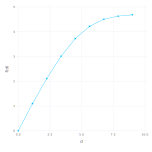

In [4]:
# Plot a piecewise linear objective
using Gadfly
function_plot = plot(x=dvalues[1,1],y=fvalues[1,1], Geom.line,Geom.point,
Guide.xlabel("d"), Guide.ylabel("f(d)"))
draw(SVG(6inch, 6inch),function_plot)

In [5]:
# Define function to construct MIP formulation for piecewice linear objective
function generateCC(dvalues,fvalues,model,x,z,s,d)
    K=length(dvalues)
    @variable(model, 0<=y[1:K-1]<=1   , Int, basename="y.$s.$d")
    @variable(model, 0<=lambda[1:K]<=1, Int, basename="lambda.$s.$d")
    @constraint(model,sum{lambda[k], k = 1:K} == 1)
    @constraint(model,sum{y[k], k = 1:K-1} == 1)
    @constraint(model,sum{dvalues[k]*lambda[k], k = 1:K} == x)
    @constraint(model,sum{fvalues[k]*lambda[k], k = 1:K} == z)
    @constraint(model,lambda[1] <= y[1])
    for k in 2:K-1
        @constraint(model,lambda[k] <= y[k-1] + y[k])
    end
    @constraint(model,lambda[K] <= y[K-1])
 end

# Generate Data
supply, demand, fvalues, dvalues = generateData(1,2,3)
snodes = length(supply); dnodes = length(demand);

# Create JuMP model, using GLPK as the solver
model = Model(solver=GLPKSolverMIP())

# Define variables
@variable(model, x[1:snodes,1:dnodes] >= 0)
@variable(model, z[1:snodes,1:dnodes] >= 0)

# Add constraints
@constraints(model, begin    
    supply_constraints[s=1:snodes], sum{x[s,d], d=1:dnodes} == supply[s]
    demand_constraints[d=1:dnodes], sum{x[s,d], s=1:snodes} == demand[d]    
end)

# Define objective
for s in 1:snodes
    for d in 1:dnodes
        generateCC(dvalues[s,d],fvalues[s,d],model,x[s,d],z[s,d],s,d)
    end
end

@objective(model, Min, sum{ z[s,d], s=1:snodes,d=1:dnodes})

# Display Model
println(model)

# Solve Model
println("Solving...")
status = solve(model)

# Display results
println("Solver status: ", status)
println("Cost: ", getobjectivevalue(model))
println("Solution: \n",getvalue(x))


Min z[1,1] + z[1,2]
Subject to
 x[1,1] + x[1,2] = 7
 x[1,1] = 6
 x[1,2] = 1
 lambda.1.1[1] + lambda.1.1[2] + lambda.1.1[3] + lambda.1.1[4] = 1
 y.1.1[1] + y.1.1[2] + y.1.1[3] = 1
 2 lambda.1.1[2] + 4 lambda.1.1[3] + 6 lambda.1.1[4] - x[1,1] = 0
 1.6389991626564955 lambda.1.1[2] + 2.596003261506767 lambda.1.1[3] + 3.2520444328225326 lambda.1.1[4] - z[1,1] = 0
 lambda.1.1[1] - y.1.1[1] ≤ 0
 lambda.1.1[2] - y.1.1[1] - y.1.1[2] ≤ 0
 lambda.1.1[3] - y.1.1[2] - y.1.1[3] ≤ 0
 lambda.1.1[4] - y.1.1[3] ≤ 0
 lambda.1.2[1] + lambda.1.2[2] + lambda.1.2[3] + lambda.1.2[4] = 1
 y.1.2[1] + y.1.2[2] + y.1.2[3] = 1
 0.3333333333333333 lambda.1.2[2] + 0.6666666666666666 lambda.1.2[3] + lambda.1.2[4] - x[1,2] = 0
 0.3051774685687901 lambda.1.2[2] + 0.5003205893949672 lambda.1.2[3] + 0.681729817826317 lambda.1.2[4] - z[1,2] = 0
 lambda.1.2[1] - y.1.2[1] ≤ 0
 lambda.1.2[2] - y.1.2[1] - y.1.2[2] ≤ 0
 lambda.1.2[3] - y.1.2[2] - y.1.2[3] ≤ 0
 lambda.1.2[4] - y.1.2[3] ≤ 0
 x[i,j] ≥ 0 ∀ i ∈ {1}, j ∈ {1,2}
 z[i,

In [6]:
# Define function to build and solve model
function solveModel(supply, demand, fvalues, dvalues, pwlformulation)
    snodes = length(supply); dnodes = length(demand);
    model = Model(solver=GLPKSolverMIP())
    @variable(model, x[1:snodes,1:dnodes] >= 0)
    @variable(model, z[1:snodes,1:dnodes] >= 0)
    @constraints(model, begin    
        supply_constraints[s=1:snodes], sum{x[s,d], d=1:dnodes} == supply[s]
        demand_constraints[d=1:dnodes], sum{x[s,d], s=1:snodes} == demand[d]    
    end)
    for s in 1:snodes
        for d in 1:dnodes
            # add pwl formulation 
            pwlformulation(dvalues[s,d],fvalues[s,d],model,x[s,d],z[s,d],s,d)
        end
    end
    @objective(model, Min, sum{ z[s,d], s=1:snodes,d=1:dnodes})
    
    println("Solving for ",string(pwlformulation)[9:end]," ...")
    tic()
    status = solve(model)
    solvetime=toq();
    println("Solver status: ", status)
    println("Cost: ", getobjectivevalue(model))
    println("Solve time: ",solvetime)
end

# Define function to construct another MIP formulation for piecewice linear objective
function generateMC(dvalues,fvalues,model,x,z,s,d)
    K=length(dvalues)
    @variable(model, 0<=y[1:K-1]<=1   , Int, basename="y.$s.$d")
    @constraint(model,sum{y[k], k = 1:K-1} == 1)
    @variable(model,xcopyVars[1:K-1],basename="x.$s.$d")
    @variable(model,zcopyVars[1:K-1],basename="z.$s.$d")
    for i in 1:(K-1)
        @constraint(model, xcopyVars[i] >= dvalues[i]*y[i])
        @constraint(model, xcopyVars[i] <= dvalues[i+1]*y[i])
        @constraint(model, zcopyVars[i] == (fvalues[i]- dvalues[i]*(fvalues[i+1]-fvalues[i])/(dvalues[i+1]-dvalues[i]))*y[i] + (fvalues[i+1]-fvalues[i])/(dvalues[i+1]-dvalues[i])*xcopyVars[i])
    end
    @constraint(model,sum{xcopyVars[k], k=1:K-1} == x)
    @constraint(model,sum{zcopyVars[k], k=1:K-1} == z)
end

# Generate Data
supply, demand, fvalues, dvalues = generateData(5,5,10)
snodes = length(supply); dnodes = length(demand);

# Solve for both formulations

for formulation in [generateCC,generateMC]
    solveModel(supply, demand, fvalues, dvalues, formulation)
end

Solving for CC ...
Solver status: Optimal
Cost: 16.475026483506262
Solve time: 1.034615453
Solving for MC ...
Solver status: Optimal
Cost: 16.00557702703166
Solve time: 0.026431172
